In [1]:
################################### CITI-ACDS Python Boot Camp summer 2021 - MINI PROJECT #################################
# Multiclass Classification of construction contract text into 3 categories: Design, COnstruction and O&M
# Name: Fahad UL Hassan
# CUID: C13169182

import base64
import string
import re
import spacy
import gensim
import logging
import nltk
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from numpy import random
from itertools import islice
from functools import reduce
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import Counter
from textblob import TextBlob, Word
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from keras import layers
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import utils
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk import pos_tag
from sklearn import tree
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.utils import shuffle
from functools import reduce
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
#################################################################################################

Using TensorFlow backend.


In [2]:
import time
start = time.time()

np.random.seed(1056)

## hide warnings##
warnings.filterwarnings('ignore')

In [6]:
## reading the csv file
Dataset = pd.read_csv('data_miniproject.csv')
Types_List = ['O&M','Design','Construction']

In [7]:
########################preprocessing#######################

#lowerCase
def LowerCase(data):
    data['Requirement'] = data['Requirement'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    return data

In [8]:
#remove punctuation
def RemovePunctuation (data):
    data['Requirement'] = data['Requirement'].str.replace('[^\w\s]','')
    return data

In [9]:
def POSTagging (data):
    tagged_data = data['Requirement'].str.split().map(pos_tag)
    tagged_data.head()
#    print(tagged_data)
    return data

In [7]:
#remove stopwords
def RemoveStopWords (data):
    stop = stopwords.words('english')
    data['Requirement'] = data['Requirement'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return data

In [8]:
def CorrectSpelling (data):
    data['Requirement'].apply(lambda x: str(TextBlob(x).correct()))
    return data

In [9]:
#remove common frequent words
def RemoveFrequentWords (data, topFrequentNumber=10):
    mask = data.Type.apply(lambda x: 'Design' in x)
    FrequentDesign= pd.Series(' '.join(data[mask]['Requirement']).split()).value_counts()[:topFrequentNumber]
    mask = data.Type.apply(lambda x: 'O&M' in x)
    FrequentOM= pd.Series(' '.join(data[mask]['Requirement']).split()).value_counts()[:topFrequentNumber]
    mask = data.Type.apply(lambda x: 'Construction' in x)
    FrequentConstruction= pd.Series(' '.join(data[mask]['Requirement']).split()).value_counts()[:topFrequentNumber]
    allFrequent=[list(FrequentDesign.index),FrequentOM.index.tolist(),FrequentConstruction.index.tolist()]
    commonFrequent=list(reduce(set.intersection, [set(item) for item in allFrequent ]))
    data['Requirement'] = data['Requirement'].apply(lambda x: " ".join(x for x in x.split() if x not in commonFrequent))
    return data

In [10]:
def RemoveUniqueWords (data):
    counts= pd.Series(' '.join(data['Requirement']).split()).value_counts()
    to_remove = counts[counts <= 1].index
    data['Requirement'] = data['Requirement'].apply(lambda x: " ".join(x for x in x.split() if x not in to_remove))
    return data

In [11]:
def AddTokens (data):
    data['Tokens'] = data['Requirement'].apply(lambda x: TextBlob(x).words)
    return data

In [12]:
def Stem(data):
    st = PorterStemmer()
    data['Requirement'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    return data

In [13]:
def Lemmatize(data):
    data['Requirement'] = data['Requirement'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return data

In [14]:
def BalanceData(data,numberofsamples=600):
    data=data.groupby('Type').apply(lambda x: x.sample(numberofsamples)).reset_index(drop=True)
    return data

In [15]:
def GetTFIDF(data,maxNGramRange=1):
    tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
    stop_words= 'english',ngram_range=(1,maxNGramRange),sublinear_tf=True)
    Dataset_vect = tfidf.fit_transform(Dataset['Requirement'])
##    idf = tfidf.idf_
##    print(dict(zip(tfidf.get_feature_names(), idf)))
    return Dataset_vect

In [16]:
def GetBagOfWords(data,maxNGramRange=1):
    bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,maxNGramRange),analyzer = "word")
    Dataset_bow = bow.fit_transform(data['Requirement'])
    return Dataset_bow

In [17]:
def RemoveNonAlphabet(data):
	data['Requirement'] = data['Requirement'].str.replace('[^0-9a-z #+_]','')
	return data

In [18]:
#################################
#Dataset=Stem(Dataset)
Dataset=Lemmatize(Dataset)
Dataset= LowerCase(Dataset)
Dataset=RemovePunctuation(Dataset)
#Dataset=POSTagging(Dataset)
Dataset=RemoveStopWords(Dataset)
#Dataset=RemoveFrequentWords(Dataset,50)
Dataset=RemoveNonAlphabet(Dataset)
#Dataset=RemoveUniqueWords(Dataset)
Dataset=AddTokens(Dataset)
tfidf= GetTFIDF(Dataset,1)
bow= GetBagOfWords(Dataset,2)
#Dataset=BalanceData(Dataset,400)
#################################
#print(Dataset[:10])

In [19]:
##################################preprocessing########################################
Dataset['Requirement'].apply(lambda x: len(x.split(' '))).sum()

X = Dataset.Requirement
y = Dataset.Type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 49)
################################# End of preprocessing########################################

In [20]:
######################## NAIVE BAYESIAN ########################
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("######################## NAIVE BAYESIAN ########################")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=Types_List))
print(confusion_matrix(y_test, y_pred))
print("############################################################\n\n")
############################################################

######################## NAIVE BIAS ########################
accuracy 0.8697850821744627
              precision    recall  f1-score   support

         O&M       0.75      0.84      0.80       185
      Design       0.88      0.91      0.90       413
Construction       0.98      0.81      0.89       193

   micro avg       0.87      0.87      0.87       791
   macro avg       0.87      0.85      0.86       791
weighted avg       0.88      0.87      0.87       791

[[156  28   1]
 [ 36 375   2]
 [ 15  21 157]]
############################################################




In [21]:
############################## Linear Support Vector Machines################################
from sklearn.linear_model import SGDClassifier      

sgd = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print("############### Linear Support Vector Machine ###############")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=Types_List))
print(confusion_matrix(y_test, y_pred))
print("#############################################################\n\n")
#############################################################  

############### Linear Support Vector Machine ###############
accuracy 0.8874841972187105
              precision    recall  f1-score   support

         O&M       0.79      0.85      0.82       185
      Design       0.90      0.92      0.91       413
Construction       0.98      0.86      0.92       193

   micro avg       0.89      0.89      0.89       791
   macro avg       0.89      0.88      0.88       791
weighted avg       0.89      0.89      0.89       791

[[158  25   2]
 [ 34 378   1]
 [  8  19 166]]
#############################################################




In [22]:
####################################LogisticRegression######################################
from sklearn.linear_model import SGDClassifier,LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', LogisticRegression(n_jobs=1, C=1e5)),])
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("##################### Logistic Regression #####################")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=Types_List))
print(confusion_matrix(y_test, y_pred))
print("###############################################################\n\n")
###############################################################

##################### Logistic Regression #####################
accuracy 0.8735777496839444
              precision    recall  f1-score   support

         O&M       0.76      0.79      0.78       185
      Design       0.89      0.91      0.90       413
Construction       0.96      0.88      0.92       193

   micro avg       0.87      0.87      0.87       791
   macro avg       0.87      0.86      0.86       791
weighted avg       0.88      0.87      0.87       791

[[147  33   5]
 [ 36 375   2]
 [ 11  13 169]]
###############################################################




In [23]:
######################################## Decision Tree ########################################
dt = Pipeline([('vect', CountVectorizer()),('clf', tree.DecisionTreeClassifier())])
#dt = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', tree.DecisionTreeClassifier())])
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("############### Decision Tree ###############")
print("Accuracy score (training): {0:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(dt.score(X_test, y_test)))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=Types_List))
print(confusion_matrix(y_test, y_pred))
print("#############################################################\n\n")
#############################################################

############### Decision Tree ###############
Accuracy score (training): 0.998
Accuracy score (validation): 0.823
accuracy 0.8230088495575221
              precision    recall  f1-score   support

         O&M       0.76      0.73      0.74       185
      Design       0.83      0.89      0.86       413
Construction       0.88      0.76      0.82       193

   micro avg       0.82      0.82      0.82       791
   macro avg       0.82      0.79      0.81       791
weighted avg       0.82      0.82      0.82       791

[[135  41   9]
 [ 33 369  11]
 [ 10  36 147]]
#############################################################




In [24]:
###############################KNeighborsClassifier####################################
from sklearn.neighbors import KNeighborsClassifier
############### KNeighborsClassifier ###############
knn = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', KNeighborsClassifier(n_neighbors=5))])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("############### KNeighborsClassifier ###############")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=Types_List))
print(confusion_matrix(y_test, y_pred))
print("#############################################################\n\n")
#################################################################################

############### KNeighborsClassifier ###############
accuracy 0.8508217446270544
              precision    recall  f1-score   support

         O&M       0.71      0.81      0.76       185
      Design       0.89      0.88      0.89       413
Construction       0.91      0.82      0.87       193

   micro avg       0.85      0.85      0.85       791
   macro avg       0.84      0.84      0.84       791
weighted avg       0.86      0.85      0.85       791

[[149  29   7]
 [ 40 365   8]
 [ 20  14 159]]
#############################################################




In [25]:
####################RandomForestClassifier#########################################
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline([('vect', CountVectorizer()),('clf', RandomForestClassifier(n_estimators=1500, max_depth=None, min_samples_split=2, random_state=0))])
#rf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', RandomForestClassifier(n_estimators=1500, max_depth=None, min_samples_split=2, random_state=0))])
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
print('accuracy %s' % accuracy_score(predictions, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))
####################################################################################

Accuracy score (training): 0.998
Accuracy score (validation): 0.870
accuracy 0.8697850821744627
Confusion Matrix:
[[145  36   4]
 [ 21 389   3]
 [  9  30 154]]

Classification Report
              precision    recall  f1-score   support

Construction       0.83      0.78      0.81       185
      Design       0.85      0.94      0.90       413
         O&M       0.96      0.80      0.87       193

   micro avg       0.87      0.87      0.87       791
   macro avg       0.88      0.84      0.86       791
weighted avg       0.87      0.87      0.87       791



In [26]:
#############################BaggingClassifier##############################################
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
kfold = model_selection.KFold(n_splits=10, random_state=7)
cart = DecisionTreeClassifier()
num_trees = 100
bagging = Pipeline([('vect', CountVectorizer()),('clf', BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=7))])
#bagging = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=7))])
eclf = bagging.fit(X_train, y_train)
predictions = eclf.predict(X_test)
print("Accuracy score (training): {0:.3f}".format(eclf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(eclf.score(X_test, y_test)))
print('accuracy %s' % accuracy_score(predictions, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))
##############################################################################################

Accuracy score (training): 0.998
Accuracy score (validation): 0.841
accuracy 0.8407079646017699
Confusion Matrix:
[[137  37  11]
 [ 27 376  10]
 [  7  34 152]]

Classification Report
              precision    recall  f1-score   support

Construction       0.80      0.74      0.77       185
      Design       0.84      0.91      0.87       413
         O&M       0.88      0.79      0.83       193

   micro avg       0.84      0.84      0.84       791
   macro avg       0.84      0.81      0.82       791
weighted avg       0.84      0.84      0.84       791



In [27]:
###################################XGBOOST#########################################
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
# Create adaboost classifer object
abc = Pipeline([('vect', CountVectorizer()),('clf', XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.5, max_depth = 5, alpha = 10, n_estimators = 50))])
#abc = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 500))])
# Train XGboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("Accuracy score (training): {0:.3f}".format(abc.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(abc.score(X_test, y_test)))
print('accuracy %s' % accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred))
######################################################################################

Accuracy score (training): 0.962
Accuracy score (validation): 0.875
accuracy 0.8748419721871049
Confusion Matrix:
[[153  26   6]
 [ 29 379   5]
 [  7  26 160]]

Classification Report
              precision    recall  f1-score   support

Construction       0.81      0.83      0.82       185
      Design       0.88      0.92      0.90       413
         O&M       0.94      0.83      0.88       193

   micro avg       0.87      0.87      0.87       791
   macro avg       0.87      0.86      0.87       791
weighted avg       0.88      0.87      0.87       791



Train on 1658 samples, validate on 185 samples
Epoch 1/6
1658/1658 [==============================] - ETA: 6s - loss: 1.1052 - acc: 0.414 - ETA: 1s - loss: 1.0496 - acc: 0.490 - ETA: 0s - loss: 1.0005 - acc: 0.517 - ETA: 0s - loss: 0.9423 - acc: 0.560 - ETA: 0s - loss: 0.8934 - acc: 0.592 - 1s 377us/step - loss: 0.8615 - acc: 0.6092 - val_loss: 0.6560 - val_acc: 0.7243
Epoch 2/6
1658/1658 [==============================] - ETA: 0s - loss: 0.6708 - acc: 0.785 - ETA: 0s - loss: 0.5755 - acc: 0.819 - ETA: 0s - loss: 0.5485 - acc: 0.829 - ETA: 0s - loss: 0.5163 - acc: 0.841 - ETA: 0s - loss: 0.5021 - acc: 0.847 - 0s 180us/step - loss: 0.4874 - acc: 0.8480 - val_loss: 0.4610 - val_acc: 0.8108
Epoch 3/6
1658/1658 [==============================] - ETA: 0s - loss: 0.3314 - acc: 0.885 - ETA: 0s - loss: 0.3514 - acc: 0.885 - ETA: 0s - loss: 0.3369 - acc: 0.893 - ETA: 0s - loss: 0.3235 - acc: 0.900 - ETA: 0s - loss: 0.3202 - acc: 0.901 - 0s 168us/step - loss: 0.3190 - acc: 0.9017 - val_loss: 0.3

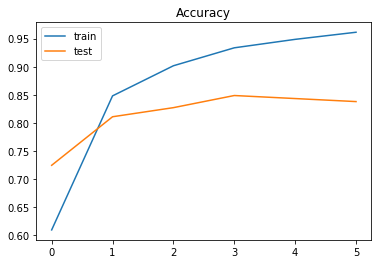

In [31]:
#######################################Feedforward Neural Network###################################
daf= {'post':Dataset['Requirement'],'tags':Dataset['Type']}
df = pd.DataFrame(daf)
my_tags = ['O&M','Design','Construction']
df = df[pd.notnull(df['tags'])]
# print(df.head(10))
# print(df['post'].apply(lambda x: len(x.split(' '))).sum())
df = shuffle(df)
df = shuffle(df)
df = shuffle(df)

max_words = 1000
batch_size = 70
epochs = 6

train_posts, test_posts, train_tags,  test_tags = train_test_split(df['post'], df['tags'], test_size=0.3, random_state=40)

#train_size = int(len(df) * .75)
#train_posts = df['post'][:train_size]
#train_tags = df['tags'][:train_size]
#
#test_posts = df['post'][train_size:]
#test_tags = df['tags'][train_size:]

tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)



# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

Types_List = ['Design','Construction','O&M']
accr = model.evaluate(x_test,y_test)
#np.argmax(y_pred, axis=1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
y_pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1),target_names=Types_List))
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();


In [29]:
end = time.time()
print(end - start)

25.59329390525818


In [30]:
#################################For N-gram Based Text Classification##############################

from sklearn import model_selection
my_types = ['Design','Construction','O&M']
   
X_train, X_test, y_train, y_test = model_selection.train_test_split(Dataset['Requirement'],Dataset['Type'],test_size=0.3, random_state=49)
      
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), max_features=5000)
tfidf_vect_ngram.fit(Dataset['Requirement'])
X_train_Tfidf =  tfidf_vect_ngram.transform(X_train)
X_test_Tfidf =  tfidf_vect_ngram.transform(X_test)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
model = tree.DecisionTreeClassifier()
model.fit(X_train_Tfidf,y_train)
# predict the labels on validation dataset
predictions_DT = model.predict(X_test_Tfidf)

# Use accuracy_score function to get the accuracy
print("DT Accuracy Score -> ",accuracy_score(predictions_DT, y_test)*100)
print(classification_report(y_test, predictions_DT,target_names=my_types))
print(confusion_matrix(y_test, predictions_DT))

DT Accuracy Score ->  81.16308470290771
              precision    recall  f1-score   support

      Design       0.71      0.71      0.71       185
Construction       0.83      0.88      0.85       413
         O&M       0.88      0.77      0.82       193

   micro avg       0.81      0.81      0.81       791
   macro avg       0.81      0.78      0.79       791
weighted avg       0.81      0.81      0.81       791

[[131  45   9]
 [ 39 363  11]
 [ 15  30 148]]
